### Skill co-occurance network

Transitions loaded: 8653
Skills kept (pre-isolate removal): 40
Edges kept (after threshold): 368
Graph: 40 nodes, 368 edges
Saved: skill_network_nodes.csv, skill_network_edges.csv


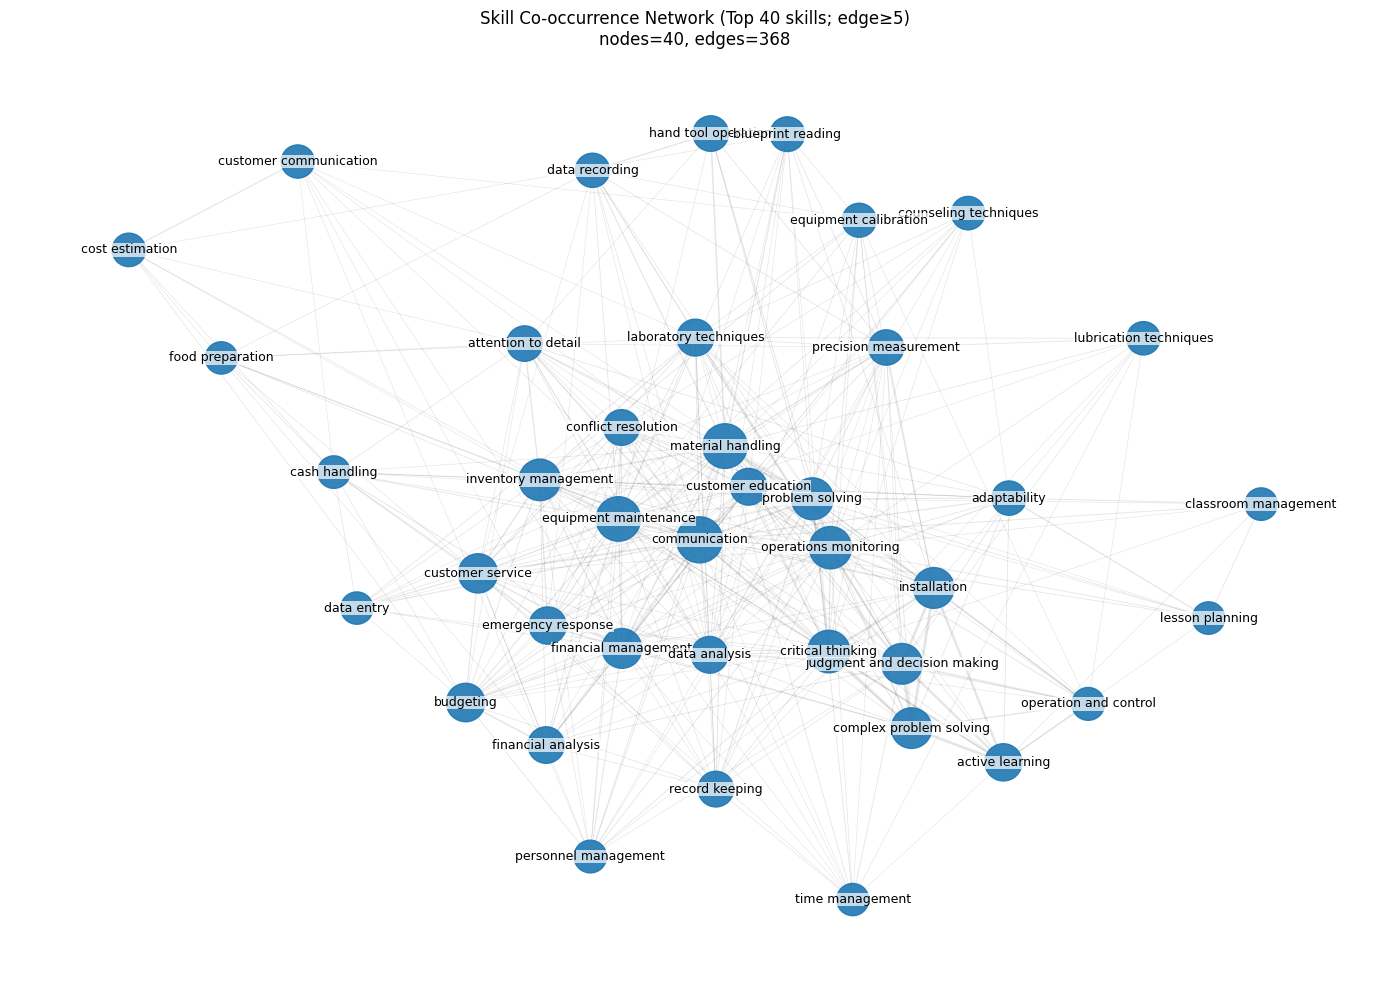

In [ ]:
# ============================================================
# Skill Co-occurrence Network Visualization
# ============================================================

import re
from collections import Counter
from itertools import combinations

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# -----------------------------
# CONFIG 
# -----------------------------
CSV_PATH = "ALL_top10_transitions_with_skills.csv"
MISSING_COL = "missing_skills"

TOP_N_SKILLS = 40          
MIN_SKILL_FREQ = 3         # drop skills that appear < 3 times (noise)
MIN_EDGE_WEIGHT = 5        # show edge only if co-occur >= 5 transitions (reduces hairball)
TOP_LABELS = 18            # label only top skills (reduces overlap)

FIGSIZE = (14, 10)
SEED = 42


# -----------------------------
# Helper: parse "a|b|c" -> list
# -----------------------------
def parse_pipe_list(x):
    if not isinstance(x, str) or not x.strip():
        return []
    skills = [s.strip().lower() for s in x.split("|") if s.strip()]
    # light cleaning
    skills = [re.sub(r"\s+", " ", s) for s in skills]
    # dedupe within a transition
    return sorted(set(skills))


# -----------------------------
# 1) Load + parse
# -----------------------------
df = pd.read_csv(CSV_PATH)

if MISSING_COL not in df.columns:
    raise ValueError(f"Column '{MISSING_COL}' not found. Columns: {list(df.columns)}")

df["missing_list"] = df[MISSING_COL].apply(parse_pipe_list)

# guard: keep max 5 missing skills per transition (your design)
df["missing_list"] = df["missing_list"].apply(lambda xs: xs[:5])

# keep only transitions with >=1 missing skill
df = df[df["missing_list"].map(len) > 0].copy()
print("Transitions loaded:", len(df))


# -----------------------------
# 2) Node weights = skill frequency
# -----------------------------
skill_freq = Counter()
for skills in df["missing_list"]:
    skill_freq.update(skills)

# drop very rare skills
skill_freq = Counter({k: v for k, v in skill_freq.items() if v >= MIN_SKILL_FREQ})

# keep top N skills
top_skills = [k for k, _ in skill_freq.most_common(TOP_N_SKILLS)]
top_skills_set = set(top_skills)
print("Skills kept (pre-isolate removal):", len(top_skills_set))


# -----------------------------
# 3) Edge weights = co-occurrence counts
# -----------------------------
edge_w = Counter()

for skills in df["missing_list"]:
    skills = sorted(set(s for s in skills if s in top_skills_set))
    for a, b in combinations(skills, 2):
        edge_w[(a, b)] += 1

# filter weak edges
edge_w = Counter({k: v for k, v in edge_w.items() if v >= MIN_EDGE_WEIGHT})
print("Edges kept (after threshold):", len(edge_w))


# -----------------------------
# 4) Build graph + remove isolates
# -----------------------------
G = nx.Graph()

for s in top_skills_set:
    if s in skill_freq:
        G.add_node(s, freq=skill_freq[s])

for (a, b), w in edge_w.items():
    if a in G.nodes and b in G.nodes:
        G.add_edge(a, b, weight=w)

# remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


# -----------------------------
# 5) Export nodes/edges 
# -----------------------------
nodes_out = (
    pd.DataFrame([{"skill": n, **G.nodes[n]} for n in G.nodes()])
    .sort_values("freq", ascending=False)
)
edges_out = (
    pd.DataFrame([{"skill_a": u, "skill_b": v, **G.edges[u, v]} for u, v in G.edges()])
    .sort_values("weight", ascending=False)
)

nodes_out.to_csv("skill_network_nodes.csv", index=False)
edges_out.to_csv("skill_network_edges.csv", index=False)
print("Saved: skill_network_nodes.csv, skill_network_edges.csv")


# -----------------------------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=SEED, weight="weight", k=0.7)

# Node sizes (compressed + capped)
freqs = np.array([G.nodes[n]["freq"] for n in G.nodes()])
sizes = 220 + 900 * (np.sqrt(freqs) / np.sqrt(freqs.max()))
sizes = np.clip(sizes, 220, 1100)

# Edge widths (compressed + capped)
weights = np.array([G.edges[u, v]["weight"] for u, v in G.edges()])
edge_widths = 0.4 + 2.0 * (weights / weights.max())
edge_widths = np.clip(edge_widths, 0.35, 2.0)

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.10)
nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.9)


labels = {n: n for n in G.nodes()}
nx.draw_networkx_labels(
    G, pos, labels=labels, font_size=9,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.2)
)

plt.title(
    f"Skill Co-occurrence Network (Top {TOP_N_SKILLS} skills; edge≥{MIN_EDGE_WEIGHT})\n"
    f"nodes={G.number_of_nodes()}, edges={G.number_of_edges()}"
)
plt.axis("off")
plt.tight_layout()
plt.savefig("skill_cooccurrence_network_all_labels.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd
import networkx as nx

# -----------------------------
# Network metrics
# -----------------------------

# 1. Degree (number of connections)
degree = dict(G.degree())

# 2. Degree centrality (normalized degree)
degree_centrality = nx.degree_centrality(G)


# -----------------------------
# Combine into one table
# -----------------------------
metrics_df = pd.DataFrame({
    "skill": list(G.nodes()),
    "degree": [degree[n] for n in G.nodes()],
    "degree_centrality": [degree_centrality[n] for n in G.nodes()],
    "frequency": [G.nodes[n]["freq"] for n in G.nodes()]
})

# Sort by degree (most connected skills first)
metrics_df = metrics_df.sort_values(
    ["degree"],
    ascending=False
)


print(metrics_df.head(10))


                           skill  degree  degree_centrality  frequency
0                  communication      34           0.871795       1258
34         operations monitoring      34           0.871795        780
9                problem solving      34           0.871795        738
7          equipment maintenance      33           0.846154       1013
38             critical thinking      27           0.692308        802
24                 data analysis      27           0.692308        356
18          inventory management      27           0.692308        706
39             material handling      27           0.692308       1025
6   judgment and decision making      26           0.666667        632
8           financial management      25           0.641026        565
